In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import svm

configuration = tflscripts.read_configuration()
tflscripts.set_dataset_folder('/home/giotto/transfer-learning-playground/datasets/')

In [2]:
def test_label_with_training_percentage(label, training_percentage):
    dfs = tflscripts.take_multiple_percentages_of_data(df, df_labels, [training_percentage, 0.2])
    X_train, df_train_labels = dfs[0]
    X_test, df_test_labels = dfs[1]

    activity_training_samples = len(df_train_labels[df_train_labels.label == label])
    non_activity_training_samples = len(df_train_labels[df_train_labels.label != label])
    print("Number of activity training samples", activity_training_samples)
    print("Number of non-activity training samples", non_activity_training_samples)

    y_train = tflscripts.get_y_for_label(df_train_labels, label)
    y_test = tflscripts.get_y_for_label(df_test_labels, label)

    clf = svm.SVC(kernel='linear', decision_function_shape='ovr')

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', clf)
    ])

    ppl.fit(X_train, y_train)
    
    positive_X_test = X_test[y_test == label]
    positive_y_test = y_test[y_test == label]

    predicted = ppl.predict(positive_X_test)
    accuracy_positive = accuracy_score(predicted, positive_y_test)
    
    print("Accuracy positive", accuracy_positive)
    
    negative_X_test = X_test[y_test != label]
    negative_y_test = y_test[y_test != label]

    predicted = ppl.predict(negative_X_test)
    accuracy_negative = accuracy_score(predicted, negative_y_test)
    
    print("Accuracy negative", accuracy_negative)
    
    return activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative

In [3]:
results = []

dataset = 'synergy-final-iter4'
device = '128.237.250.218'

activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Null",
    "Kettle",
    "Chopping food",
    "Knocking",
    "Vacuum cleaning",
    "Blender running",
    "Alarm"
]
activities_i = [configuration['activities'].index(a) for a in activities]

for activity in activities:

    label = configuration['activities'].index(activity)

    df, df_labels = tflscripts.read_and_filter_dataset(
            dataset + '-1s',
            device,
            use_features='.*',
            use_activities=activities_i,
            scale=True,
            with_feature_selection=False)

    df = df.loc[df.index.isin(df_labels.index)]
    df_labels = df_labels.loc[df_labels.index.isin(df.index)]

    for training_percentage in range(1, 10):
        training_percentage = training_percentage / 10

        print(activity, training_percentage)

        activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative = \
            test_label_with_training_percentage(label, training_percentage)

        results.append({
            'activity': activity,
            'training_percentage': training_percentage,
            'accuracy_positive': accuracy_positive,
            'accuracy_negative': accuracy_negative,
            'activity_training_samples': activity_training_samples,
            'non_activity_training_samples': non_activity_training_samples
        })

Dishes 0.1
Number of activity training samples 55
Number of non-activity training samples 417
Accuracy positive 0.892857142857
Accuracy negative 0.992779783394
Dishes 0.2
Number of activity training samples 128
Number of non-activity training samples 815
Accuracy positive 0.973913043478
Accuracy negative 0.990338164251
Dishes 0.3
Number of activity training samples 178
Number of non-activity training samples 1236
Accuracy positive 0.973214285714
Accuracy negative 0.998796630566
Dishes 0.4
Number of activity training samples 234
Number of non-activity training samples 1652
Accuracy positive 0.973684210526
Accuracy negative 0.997587454765
Dishes 0.5
Number of activity training samples 322
Number of non-activity training samples 2036
Accuracy positive 0.979166666667
Accuracy negative 0.996458087367
Dishes 0.6
Number of activity training samples 350
Number of non-activity training samples 2479
Accuracy positive 0.990566037736
Accuracy negative 0.99761051374
Dishes 0.7
Number of activity tr

Number of activity training samples 460
Number of non-activity training samples 3312
Accuracy positive 0.991666666667
Accuracy negative 0.998784933171
Chopping food 0.9
Number of activity training samples 522
Number of non-activity training samples 3722
Accuracy positive 1.0
Accuracy negative 1.0
Knocking 0.1
Number of activity training samples 6
Number of non-activity training samples 466
Accuracy positive 0.625
Accuracy negative 1.0
Knocking 0.2
Number of activity training samples 8
Number of non-activity training samples 935
Accuracy positive 0.666666666667
Accuracy negative 1.0
Knocking 0.3
Number of activity training samples 20
Number of non-activity training samples 1394
Accuracy positive 1.0
Accuracy negative 0.996794871795
Knocking 0.4
Number of activity training samples 23
Number of non-activity training samples 1863
Accuracy positive 1.0
Accuracy negative 0.997865528282
Knocking 0.5
Number of activity training samples 15
Number of non-activity training samples 2343
Accuracy p

Increasing number of training samples without transfer


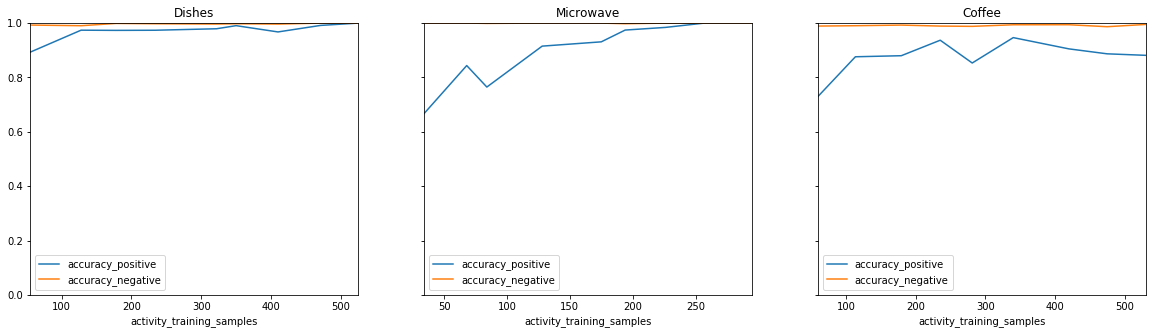

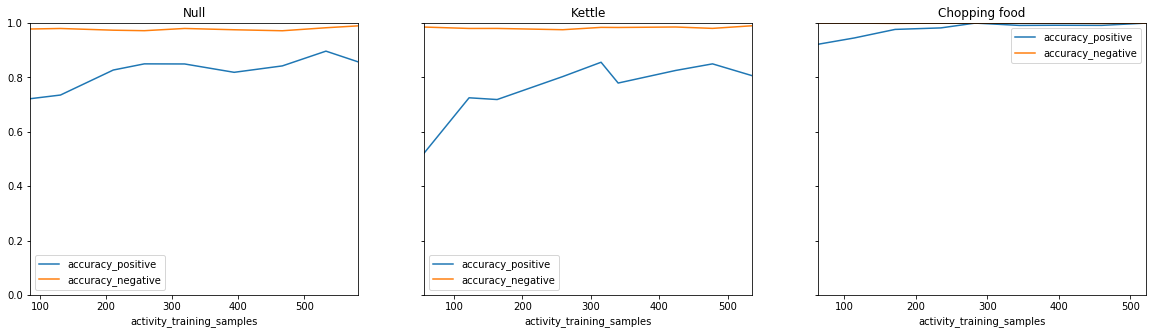

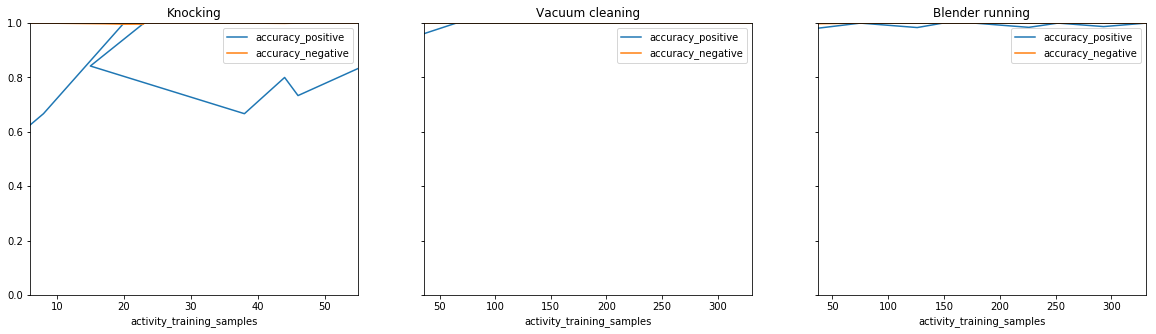

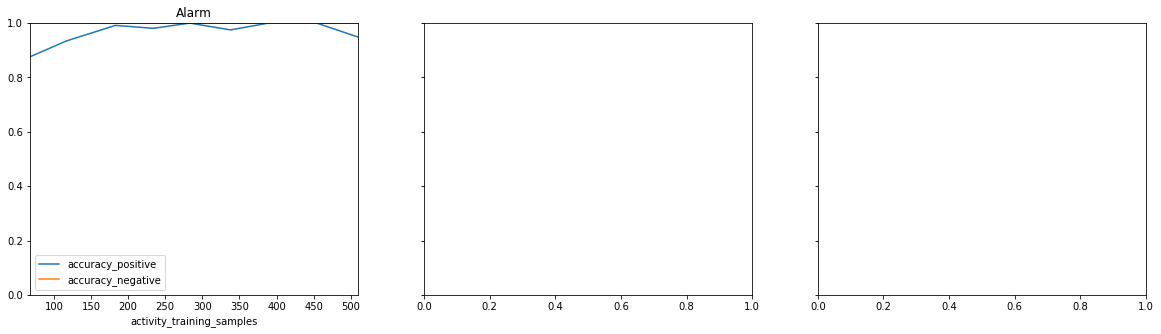

In [4]:
print('Increasing number of training samples without transfer')
plt.rcParams["figure.figsize"] = (20, 5)

df = pd.DataFrame(results)

axes = []
for activity in df.activity.unique():
    if len(axes) == 0:
        f, axes = plt.subplots(1, 3, sharex=False, sharey=True)
        axes = axes.tolist()

        plt.ylim([0,1])
    ax = axes.pop(0)

    activity_df = df.loc[df.activity == activity]
    activity_df = activity_df[['activity_training_samples', 'accuracy_positive', 'accuracy_negative']]
    activity_df = activity_df.set_index('activity_training_samples')
    activity_df.plot(ax=ax)
    matplotlib.pyplot.sca(ax)
    plt.title(activity)